In [1]:
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Web-Science/tweets.csv')
data

,_id,text
0,1409477134209458181,My son and I went on a tour to the Allianz Are...
1,1409477134691835908,@Veronic35709033 @SFODan @SimonCalder @grantsh...
2,1409477135228719105,(Ethereum looks to retake $2K days before Lond...
3,1409477135711064066,No Riley Dean in the squad either. Suggests an...
4,1409477137204191238,Highest ever temperatures in Canada - and US n...
...,...,...
53394,1409610186768142341,Will England be boycotting Qatar then where be...
53395,1409610187179180039,AHAHA NARR BC I WAS LIKE AYYYYY
53396,1409610187162411011,I’m in tears so many pogba haters were waiting...
53397,1409610187569303557,"Peter, top 5 countries: 1. Chad, 2. Taiwan, 3...."


In [7]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
import string
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

#add punctuation char's to stopwords list
stop_words += list(string.punctuation) # <-- contains !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

#add integers
stop_words += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
import re
def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

data['text']= data['text'].apply(url_free_text)

In [9]:
from nltk.tokenize import word_tokenize
def tokenize_lowercase(text):
    tokens = word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed
  
data['text']= data['text'].apply(tokenize_lowercase)

In [10]:
def remove_nums(text_object):
    no_nums = list(filter(lambda x: x.isalpha(), text_object))
    return no_nums

data['text'] = data['text'].apply(remove_nums)

In [11]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text(df_text):
    lemmatized =[]
    for w in df_text:
        lemmatized.append(lemmatizer.lemmatize(w))
    return lemmatized

data['text'] = data['text'].apply(lemmatize_text)

In [12]:
data['text']

0        [son, went, tour, allianz, arena, admiring, se...
1        [sfodan, simoncalder, grantshapps, think, told...
2        [ethereum, look, retake, day, london, hard, fo...
3        [riley, dean, squad, either, suggests, partner...
4        [highest, ever, temperature, canada, u, likely...
                               ...                        
53394    [england, boycotting, qatar, homosexual, illeg...
53395                      [ahaha, narr, bc, like, ayyyyy]
53396    [tear, many, pogba, hater, waiting, cook, saw,...
53397    [peter, top, country, chad, taiwan, scotland, ...
53398    [spacex, first, space, tourist, reveal, suit, ...
Name: text, Length: 53399, dtype: object

In [13]:
all_words = [word for tokens in data['text'] for word in tokens]
tweet_lengths = [len(tokens) for tokens in data['text']]
vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

695345 words total, with a vocabulary size of 64217
Max tweet length is 69


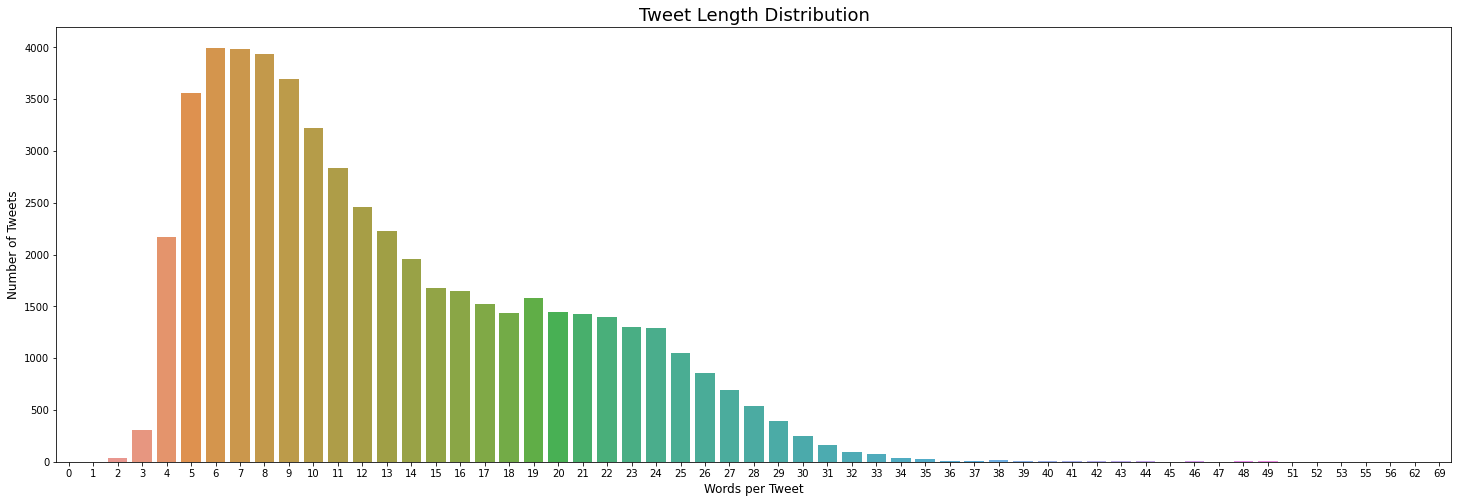

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize = (25,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [15]:
from nltk.probability import FreqDist

#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in data['text'] for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(30)

[('uk', 7404),
 ('england', 6025),
 ('new', 5274),
 ('amp', 4068),
 ('like', 3260),
 ('get', 3070),
 ('london', 2972),
 ('one', 2949),
 ('people', 2922),
 ('york', 2899),
 ('time', 2811),
 ('u', 2515),
 ('would', 2395),
 ('labour', 2118),
 ('year', 2086),
 ('know', 1906),
 ('see', 1882),
 ('day', 1878),
 ('game', 1861),
 ('need', 1849),
 ('think', 1818),
 ('back', 1790),
 ('good', 1780),
 ('go', 1777),
 ('scotland', 1691),
 ('conservative', 1608),
 ('make', 1550),
 ('still', 1543),
 ('want', 1512),
 ('love', 1472)]

In [16]:
#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

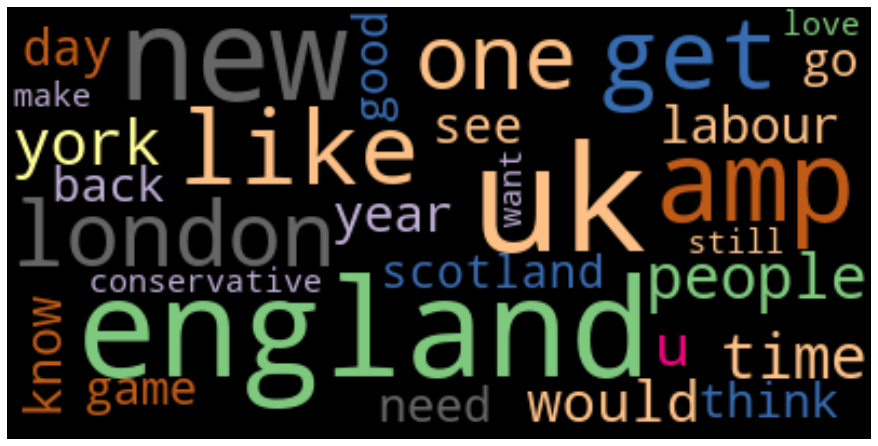

In [17]:

from wordcloud import WordCloud

#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_30_cloud.png')

plt.show()

In [18]:

# Create a id2word dictionary
id2word = Dictionary(data['text'])
print(len(id2word))

64217


In [19]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

25947


In [20]:

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in data['text']]

In [21]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

In [22]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [23]:
# Create Topics
topics = [' '.join(t[0:20]) for t in words]

In [24]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"Topic {id} ")
    print(t, end="\n\n")

Topic 0 
uk love amp time england like take loveisland one new

Topic 1 
england labour uk germany amp tomorrow need win like look

Topic 2 
uk amp london scotland new u get people covid go

Topic 3 
england london game uk know people make new like france

Topic 4 
new york like one year get people day back uk



In [25]:

# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=data['text'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -8.620935265730441

Coherence Score:  0.20457114492991196


2nd model
with number of topics = 20

In [26]:
two_model = LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, workers=12, passes=5)
two_words = [re.findall(r'"([^"]*)"',t2[1]) for t2 in two_model.print_topics()]
two_topics = [' '.join(t2[0:20]) for t2 in two_words]
for id, t2 in enumerate(two_topics): 
    print(f"------ Topic {id} ------")
    print(t2, end="\n\n")

------ Topic 0 ------
labour tory amp conservative party vote still one day people

------ Topic 1 ------
england game tomorrow germany time win football france team v

------ Topic 2 ------
uk amp minister good time prime england well loveisland one

------ Topic 3 ------
uk like new wind rain back york london news binance

------ Topic 4 ------
uk death loveisland vaccine case know school covid first people

------ Topic 5 ------
love uk people island u england would like one get

------ Topic 6 ------
uk england conservative like amp eu day want think labour

------ Topic 7 ------
london uk year wale would great best boris people woman

------ Topic 8 ------
uk boris johnson country eu like government hancock people think

------ Topic 9 ------
people labour one uk work u like amp world right

------ Topic 10 ------
get scotland amp need think go year one let still

------ Topic 11 ------
uk year united manchester england like would good need london

------ Topic 12 ------
benzema n

In [27]:
# Compute Perplexity
# a measure of how good the model is. lower the better
two_perplexity = two_model.log_perplexity(corpus)
print('\nPerplexity: ', two_perplexity) 

# Compute Coherence Score
two_coherence_model = CoherenceModel(model=two_model, texts=data['text'], 
                                   dictionary=id2word, coherence='c_v')
two_coherence_lda_model_base = two_coherence_model.get_coherence()
print('\nCoherence Score: ', two_coherence_lda_model_base)


Perplexity:  -8.841893195320267

Coherence Score:  0.32670822598172916


In [28]:
last_model = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=68,
                       random_state=42,
                       chunksize=2000,
                       passes=25,
                       decay=0.5,
                       iterations=70)

last_words = [re.findall(r'"([^"]*)"',t3[1]) for t3 in last_model.print_topics()]
last_topics = [' '.join(t3[0:20]) for t3 in last_words]


In [29]:
# Compute Perplexity
# a measure of how good the model is. lower the better
last_perplexity = last_model.log_perplexity(corpus)
print('\nPerplexity: ', last_perplexity) 

# Compute Coherence Score
last_coherence_model = CoherenceModel(model=last_model, texts=data['text'], 
                                   dictionary=id2word, coherence='c_v')
last_coherence_lda_model_base = last_coherence_model.get_coherence()
print('\nCoherence Score: ', last_coherence_lda_model_base)


Perplexity:  -9.234749827641524

Coherence Score:  0.3994241455622251


In [30]:
print(last_model.print_topics())

[(46, '0.067*"change" + 0.060*"yes" + 0.058*"photo" + 0.042*"black" + 0.042*"posted" + 0.039*"london" + 0.036*"street" + 0.033*"west" + 0.033*"video" + 0.030*"side"'), (35, '0.060*"london" + 0.045*"house" + 0.040*"head" + 0.039*"road" + 0.038*"close" + 0.037*"train" + 0.036*"huge" + 0.034*"fire" + 0.031*"station" + 0.027*"near"'), (10, '0.070*"check" + 0.037*"move" + 0.032*"future" + 0.028*"project" + 0.024*"room" + 0.023*"worth" + 0.020*"idiot" + 0.018*"earlier" + 0.017*"gov" + 0.016*"happens"'), (31, '0.175*"like" + 0.068*"really" + 0.065*"look" + 0.033*"lot" + 0.028*"feel" + 0.024*"maybe" + 0.022*"bit" + 0.020*"would" + 0.017*"good" + 0.016*"sound"'), (4, '0.054*"million" + 0.034*"wo" + 0.033*"running" + 0.024*"seat" + 0.023*"amp" + 0.023*"gbnews" + 0.020*"meeting" + 0.020*"telling" + 0.020*"plus" + 0.019*"meet"'), (17, '0.048*"story" + 0.046*"link" + 0.037*"idea" + 0.030*"outside" + 0.029*"comment" + 0.027*"market" + 0.024*"per" + 0.021*"info" + 0.021*"seem" + 0.019*"special"'), (5

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=last_model, corpus=corpus, texts=data['text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic


In [32]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8592,"got, two, racing, ca, oxford, wait, second, early, given, study","[tparkersanditon, wingmanrobinson, sincere, apology, redeem, london]"
1,1.0,0.8905,"right, minister, prime, person, understand, canada, human, hold, lad, australia","[u, broil, pakistani, grappling, temperature, hotter, human, body, handle]"
2,2.0,0.7153,"free, kid, amp, centre, lockdown, update, app, daily, staff, mile","[northern, update, southport, alderley, edge, due, terminated, bolton, open, safari, free, app, ..."
3,3.0,0.7537,"woman, top, season, touch, three, manager, waiting, american, training, first","[reimburse, killstar, uk, gc]"
4,4.0,0.7164,"million, wo, running, seat, amp, gbnews, meeting, telling, plus, meet","[ceasefire, declared, tigray, war, tigray, peaceupontigray, tigrayisprevailing]"
5,5.0,0.6716,"oh, nh, matter, cause, save, flag, safe, student, trust, clear","[sanpellegrino, get, toiletpaper, treatment]"
6,6.0,0.8358,"guy, trying, trump, lose, pen, box, charge, sent, fake, daughter","[jtynrhos, nationcymru, guy, english, call, wale, waleshire]"
7,7.0,0.7537,"business, law, deal, uk, company, order, rather, driver, government, secretary","[coming, nia, country, director]"
8,8.0,0.8625,"penalty, taking, le, power, national, score, including, member, interest, starting","[since, military, seized, power, myanmar, number, myanmar, national, taking, refuge, india, mizo..."
9,9.0,0.8358,"world, dublin, wish, league, sunday, cup, south, sheffield, super, shirt","[alisongilliland, elected, lord, mayor, dublin]"


In [33]:
def compute_results(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        print(num_topics)
        model_list.append(last_model)
        coherencemodel = CoherenceModel(model=last_model, texts=data['text'], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(last_model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

In [35]:

model_list, coherence_values, perplexity_values = compute_results(dictionary=id2word, corpus=corpus, texts=data['text'], start=10, limit=90, step=10)
print(model_list)
print(coherence_values)
print(perplexity_values)

10
20
30
40
50
60
70
80
[<gensim.models.ldamulticore.LdaMulticore object at 0x7f0bbfee6f90>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f0bbfee6f90>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f0bbfee6f90>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f0bbfee6f90>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f0bbfee6f90>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f0bbfee6f90>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f0bbfee6f90>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f0bbfee6f90>]
[0.3994241455622251, 0.3994241455622251, 0.3994241455622251, 0.3994241455622251, 0.3994241455622251, 0.3994241455622251, 0.3994241455622251, 0.3994241455622251]
[-9.234739827767486, -9.234780428163614, -9.23478413224728, -9.234840183409045, -9.234830447674637, -9.23464816106913, -9.234677509386099, -9.234734137840512]


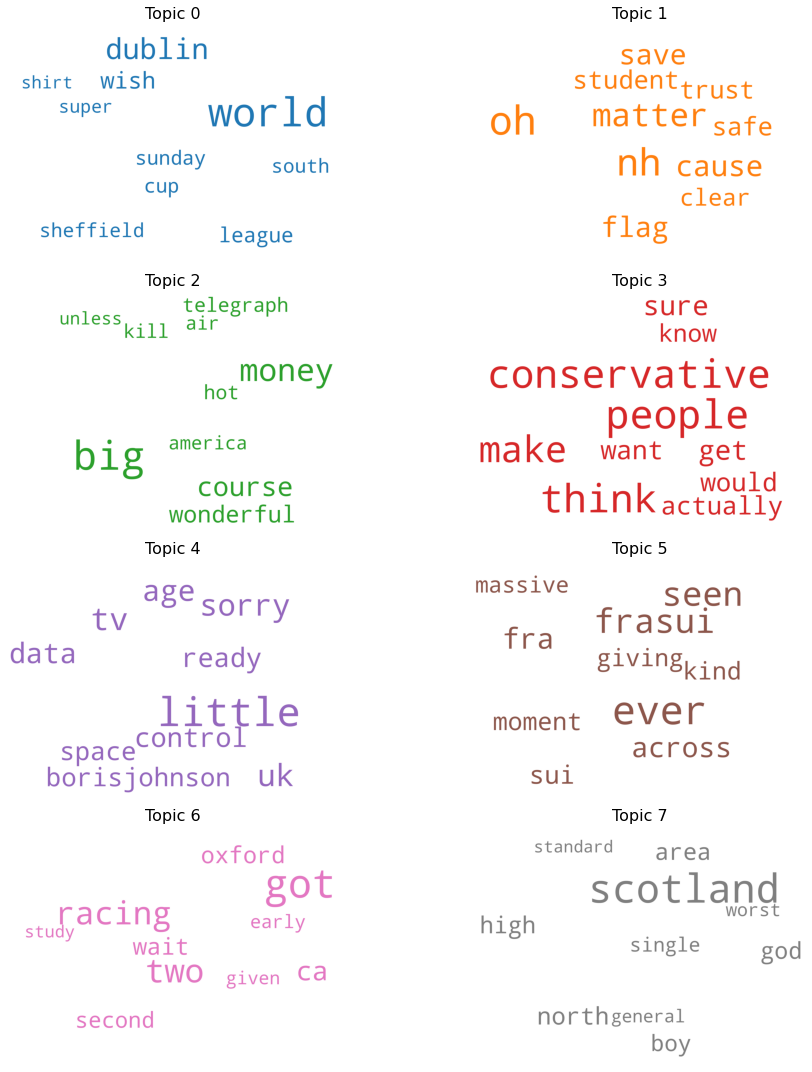

In [36]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = last_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()